# Preliminaries
First install critical dependencies not already on the Kaggle docker image

In [1]:
!pip install keras==2.2.4 # critical dependency
!pip install -q bert-tensorflow

     |████████████████████████████████| 317kB 2.7MB/s 
  Found existing installation: Keras 2.3.0
    Uninstalling Keras-2.3.0:
      Successfully uninstalled Keras-2.3.0


Write requirements to file, anytime you run it, in case you have to go back and recover dependencies.

Latest known such requirements are hosted for each notebook in the companion github repo, and can be pulled down and installed here if needed. Companion github repo is located at https://github.com/azunre/transfer-learning-for-nlp

In [2]:
!pip freeze > kaggle_image_requirements.txt

In [3]:
# Import neural network libraries
import tensorflow as tf
import tensorflow_hub as hub
from bert.tokenization import FullTokenizer
from tensorflow.keras import backend as K

# Initialize session
sess = tf.Session()

In [4]:
# Some other key imports
import os
import re
import pandas as pd
import numpy as np
from tqdm import tqdm

# Define Tokenization, Stop-word and Punctuation Removal Functions
Before proceeding, we must decide how many samples to draw from each class. We must also decide the maximum number of tokens per email, and the maximum length of each token. This is done by setting the following overarching hyperparameters

In [5]:
# Params for bert model and tokenization
Nsamp = 1000 # number of samples to generate in each class - 'spam', 'not spam'
maxtokens = 200 # the maximum number of tokens per document
maxtokenlen = 100 # the maximum length of each token

**Tokenization**

In [6]:
def tokenize(row):
    if row is None or row is '':
        tokens = ""
    else:
        try:
            tokens = row.split(" ")[:maxtokens]
        except:
            tokens=""
    return tokens

**Use regular expressions to remove unnecessary characters**

Next, we define a function to remove punctuation marks and other nonword characters (using regular expressions) from the emails with the help of the ubiquitous python regex library. In the same step, we truncate all tokens to hyperparameter maxtokenlen defined above.

In [7]:
def reg_expressions(row):
    tokens = []
    try:
        for token in row:
            token = token.lower()
            token = re.sub(r'[\W\d]', "", token)
            token = token[:maxtokenlen] # truncate token
            tokens.append(token)
    except:
        token = ""
        tokens.append(token)
    return tokens

**Stop-word removal**

Let’s define a function to remove stopwords - words that occur so frequently in language that they offer no useful information for classification. This includes words such as “the” and “are”, and the popular library NLTK provides a heavily-used list that will employ.

In [8]:
import nltk

nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = stopwords.words('english')    
print(stopwords) # see default stopwords

def stop_word_removal(row):
    token = [token for token in row if token not in stopwords]
    token = filter(None, token)
    return token

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both'

# Read and Preprocess Enron dataset
Read Enron dataset and get a sense for the data by printing sample messages to screen

In [9]:
# Input data files are available in the "../input/" directory.
filepath = "../input/enron-email-dataset/emails.csv"

# Read the data into a pandas dataframe called emails
emails = pd.read_csv(filepath)

print("Successfully loaded {} rows and {} columns!".format(emails.shape[0], emails.shape[1]))
print(emails.head())

Successfully loaded 517401 rows and 2 columns!
                       file                                            message
0     allen-p/_sent_mail/1.  Message-ID: <18782981.1075855378110.JavaMail.e...
1    allen-p/_sent_mail/10.  Message-ID: <15464986.1075855378456.JavaMail.e...
2   allen-p/_sent_mail/100.  Message-ID: <24216240.1075855687451.JavaMail.e...
3  allen-p/_sent_mail/1000.  Message-ID: <13505866.1075863688222.JavaMail.e...
4  allen-p/_sent_mail/1001.  Message-ID: <30922949.1075863688243.JavaMail.e...


In [10]:
# take a closer look at the first email
print(emails.loc[0]["message"])

Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>
Date: Mon, 14 May 2001 16:39:00 -0700 (PDT)
From: phillip.allen@enron.com
To: tim.belden@enron.com
Subject: 
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: Tim Belden <Tim Belden/Enron@EnronXGate>
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail
X-Origin: Allen-P
X-FileName: pallen (Non-Privileged).pst

Here is our forecast

 


In [11]:
# Separate headers from the message bodies
import email

def extract_messages(df):
    messages = []
    for item in df["message"]:
        # Return a message object structure from a string
        e = email.message_from_string(item)    
        # get message body  
        message_body = e.get_payload()
        messages.append(message_body)
    print("Successfully retrieved message body from e-mails!")
    return messages

bodies = extract_messages(emails)

Successfully retrieved message body from e-mails!


In [12]:
# extract random 10000 enron email bodies for building dataset
import random
bodies_df = pd.DataFrame(random.sample(bodies, 10000))

# expand default pandas display options to make emails more clearly visible when printed
pd.set_option('display.max_colwidth', 300)

bodies_df.head() # you could do print(bodies_df.head()), but Jupyter displays this nicer for pandas DataFrames

,0
0,I forgot to attach the program file. Here it is\n\n-chonawee\n\n---------------------- Forwarded by Chonawee Supatgiat/Corp/Enron on \n10/17/2000 09:13 PM ---------------------------\n\n\nChonawee Supatgiat\n10/17/2000 09:13 PM\nTo: Mike A Roberts/HOU/ECT@ECT\ncc: Vince J Kaminski/HOU/ECT@ECT \n...
1,Mark - \n\nMike Robison and I have finalized the form of GTC's for ECFC and are \nforwarding them to you for further distribution. Thanks.\n\n \n\nJohn - \n\nThe only modifications to ECFC's online GTC's are as follows:\n\nContract Formation In order to maintain consistency with the other produ...
2,"Good Morning,\n\nJust wanted to let all of you know that Damon Williams will be a bit late \nthis morning due to the bad weather. But he will be in.\n\nIf you need any help in the meantime please let me know.\n\nThank you,\nMargaret Doucette\nx5-7892"
3,---------------------- Forwarded by Dana Davis/HOU/ECT on 02/15/2001 10:27 AM \n---------------------------\n\n\nDaily-Blessings <dailyblessings@lists.postmastergeneral.com> on 02/14/2001 \n10:51:04 PM\nTo: dana.davis@enron.com\ncc: \nSubject: Daily-Blessings 2/15/01\n\n\nDaily-Blessing\nMathem...
4,"You may just need warm bodies at this point, big boy"


The following (commented out) code is arguably the more "pythonic" way of achieving the extraction of bodies from messages. It is only 2 lines long and achieves the same result. However, we feel the code above is more transparent with regards to how the processing is carried out, and as such leave this here for the python experts if they prefer.

In [13]:
#messages = emails["message"].apply(email.message_from_string)
#bodies_df = messages.apply(lambda x: x.get_payload()).sample(10000)

# Read and Preprocess Fraudulent "419" Email Corpus

In [14]:
filepath = "../input/fraudulent-email-corpus/fradulent_emails.txt"
with open(filepath, 'r',encoding="latin1") as file:
    data = file.read()
    
# split on a code word appearing close to the beginning of each email
fraud_emails = data.split("From r")

print("Successfully loaded {} spam emails!".format(len(fraud_emails)))

Successfully loaded 3978 spam emails!


In [15]:
fraud_bodies = extract_messages(pd.DataFrame(fraud_emails,columns=["message"],dtype=str))
fraud_bodies_df = pd.DataFrame(fraud_bodies[1:])

fraud_bodies_df.head() # you could do print(fraud_bodies_df.head()), but Jupyter displays this nicer for pandas DataFrames

Successfully retrieved message body from e-mails!


,0
0,"FROM:MR. JAMES NGOLA.\nCONFIDENTIAL TEL: 233-27-587908.\nE-MAIL: (james_ngola2002@maktoob.com).\n\nURGENT BUSINESS ASSISTANCE AND PARTNERSHIP.\n\n\nDEAR FRIEND,\n\nI AM ( DR.) JAMES NGOLA, THE PERSONAL ASSISTANCE TO THE LATE CONGOLESE (PRESIDENT LAURENT KABILA) WHO WAS ASSASSINATED BY HIS BODY G..."
1,"Dear Friend,\n\nI am Mr. Ben Suleman a custom officer and work as Assistant controller of the Customs and Excise department Of the Federal Ministry of Internal Affairs stationed at the Murtala Mohammed International Airport, Ikeja, Lagos-Nigeria.\n\nAfter the sudden death of the former Head of s..."
2,"FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF ELEME KINGDOM \nCHIEF DANIEL ELEME, PHD, EZE 1 OF ELEME.E-MAIL \nADDRESS:obong_715@epatra.com \n\nATTENTION:PRESIDENT,CEO Sir/ Madam. \n\nThis letter might surprise you because we have met\nneither in person nor by correspondence. But I believe\nit is..."
3,"FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF ELEME KINGDOM \nCHIEF DANIEL ELEME, PHD, EZE 1 OF ELEME.E-MAIL \nADDRESS:obong_715@epatra.com \n\nATTENTION:PRESIDENT,CEO Sir/ Madam. \n\nThis letter might surprise you because we have met\nneither in person nor by correspondence. But I believe\nit is..."
4,"Dear sir, \n \nIt is with a heart full of hope that I write to seek your help in respect of the context below. I am Mrs. Maryam Abacha the former first lady of the former Military Head of State of Nigeria General Sani Abacha whose sudden death occurred on 8th of June 1998 as a result of cardiac ..."


# Putting It All Together To Assemble Dataset

Now, putting all the preprocessing steps together we assemble our dataset...

In [16]:
import random

# Convert everything to lower-case, truncate to maxtokens and truncate each token to maxtokenlen
EnronEmails = bodies_df.iloc[:,0].apply(tokenize)
EnronEmails = EnronEmails.apply(stop_word_removal)
EnronEmails = EnronEmails.apply(reg_expressions)
EnronEmails = EnronEmails.sample(Nsamp)

SpamEmails = fraud_bodies_df.iloc[:,0].apply(tokenize)
SpamEmails = SpamEmails.apply(stop_word_removal)
SpamEmails = SpamEmails.apply(reg_expressions)
SpamEmails = SpamEmails.sample(Nsamp)

raw_data = pd.concat([SpamEmails,EnronEmails], axis=0).values

In [17]:
print("Shape of combined data represented as numpy array is:")
print(raw_data.shape)
print("Data represented as numpy array is:")
print(raw_data)

# corresponding labels
Categories = ['spam','notspam']
header = ([1]*Nsamp)
header.extend(([0]*Nsamp))

Shape of combined data represented as numpy array is:
(2000,)
Data represented as numpy array is:
[list(['dear', 'friendi', 'mohammed', 'abacha', 'eldest', 'son', 'late', 'president', 'nigeriai', 'falsely', 'acussed', 'murder', 'imprisoned', 'thanks', 'toallahi', 'released', 'innosence', 'well', 'dear', 'friend', 'needyour', 'assistance', 'reeived', 'money', 'behalf', 'governmentis', 'making', 'plans', 'seize', 'them', 'myfathers', 'ownplease', 'view', 'site', 'read', 'content', 'carefullyhttpnewsbbccoukhienglishworldafricanewsid_stmthe', 'amnt', '', 'millionit', 'defaced', 'security', 'reason', 'currentlywith', 'security', 'company', 'abroad', 'all', 'needed', 'isfor', 'instruct', 'company', 'hand', 'money', 'you', 'iwill', 'renumerate', '', 'end', 'ht', 'solicityour', 'trust', 'transaction', 'i', 'confined', 'kano', 'allmy', 'callsare', 'monitoredso', 'get', 'private', 'attorney', 'get', 'neededinformationsbest', 'regardsmohammed', 'abachanb', 'kindly', 'contact', 'via', 'eai'])
 lis

In [18]:
# function for shuffling data in unison with labels/header
def unison_shuffle(a, b):
    p = np.random.permutation(len(b))
    data = a[p]
    header = np.asarray(b)[p]
    return data, header

# function for converting data into the right format, due to the difference in required format from sklearn models
# we expect a single string per email here, versus a list of tokens for the sklearn models previously explored
def convert_data(raw_data,header):
    converted_data, labels = [], []
    for i in range(raw_data.shape[0]):
        out = ' '.join(raw_data[i])
        converted_data.append(out)
        labels.append(header[i])
        #print(i)
    converted_data = np.array(converted_data, dtype=object)[:, np.newaxis]
    
    return converted_data, np.array(labels)

raw_data, header = unison_shuffle(raw_data, header)

# split into independent 70% training and 30% testing sets
idx = int(0.7*raw_data.shape[0])
# 70% of data for training
train_x, train_y = convert_data(raw_data[:idx],header[:idx])
# remaining 30% for testing
test_x, test_y = convert_data(raw_data[idx:],header[idx:])

print("train_x/train_y list details, to make sure it is of the right form:")
print(len(train_x))
print(train_x)
print(train_y[:5])
print(train_y.shape)

train_x/train_y list details, to make sure it is of the right form:
1400
[[' forwarded phillip m lovehouect   pm bryan hull  pmto oneal d winfreehouectect phillip m lovehouectect david baumbachhouectect michael waltershouectect eric basshouectect matthew lenharthouectect daren j farmerhouectect jody crookcorpenronenron timothy blanchardhoueesees chad landryhouectectcc subject fw grandma wassup forwarded bryan hullhouect   pm  to bryan hullhouectectcc subject fw grandma wassup forwarded cecilia olverahouect   pm  forwarded alex saldanahouect   pm  grandmawassupmpg  grandmawassupmpg']
 ['froma misse fatima mandefe dakar e senegalc west africaemaila fatimamandefyahooecom cmailtoafatimamandefyahooecome dear onec my warmest greeting name lorde i fatima mandef i inheritated important late father died recent crisis cote divoireethen ran senegal savec i wish request assistance investing sum lucrative venture manufacturing real estate management countrye i five millionc seven hundred thousand u

Since 70% of 2000 is 1400, looks good! (for Nsamp=1000)

Onwards!

# Build, Train and Evaluate BERT Model
First define critical functions that define various components of the BERT model 

In [19]:
class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.
    Args:
      guid: Unique id for the example.
      text_a: string. The untokenized text of the first sequence. For single
        sequence tasks, only this sequence must be specified.
      text_b: (Optional) string. The untokenized text of the second sequence.
        Only must be specified for sequence pair tasks.
      label: (Optional) string. The label of the example. This should be
        specified for train examples, but not for test examples.
    """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label


def create_tokenizer_from_hub_module(bert_path):
    """Get the vocab file and casing info from the Hub module."""
    bert_module = hub.Module(bert_path)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    vocab_file, do_lower_case = sess.run(
        [tokenization_info["vocab_file"], tokenization_info["do_lower_case"]]
    )

    return FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case)


def convert_single_example(tokenizer, example, max_seq_length=256):
    """Converts a single `InputExample` into a single `InputFeatures`."""

    tokens_a = tokenizer.tokenize(example.text_a)
    if len(tokens_a) > max_seq_length - 2:
        tokens_a = tokens_a[0 : (max_seq_length - 2)]

    tokens = []
    segment_ids = []
    tokens.append("[CLS]")
    segment_ids.append(0)
    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(0)
    tokens.append("[SEP]")
    segment_ids.append(0)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    return input_ids, input_mask, segment_ids, example.label


def convert_examples_to_features(tokenizer, examples, max_seq_length=256):
    """Convert a set of `InputExample`s to a list of `InputFeatures`."""

    input_ids, input_masks, segment_ids, labels = [], [], [], []
    for example in tqdm(examples, desc="Converting examples to features"):
        input_id, input_mask, segment_id, label = convert_single_example(
            tokenizer, example, max_seq_length
        )
        input_ids.append(input_id)
        input_masks.append(input_mask)
        segment_ids.append(segment_id)
        labels.append(label)
    return (
        np.array(input_ids),
        np.array(input_masks),
        np.array(segment_ids),
        np.array(labels).reshape(-1, 1),
    )


def convert_text_to_examples(texts, labels):
    """Create InputExamples"""
    InputExamples = []
    for text, label in zip(texts, labels):
        InputExamples.append(
            InputExample(guid=None, text_a=" ".join(text), text_b=None, label=label)
        )
    return InputExamples

Next, we define a custom tf hub BERT layer

In [20]:
class BertLayer(tf.keras.layers.Layer):
    def __init__(
        self,
        n_fine_tune_layers=10,
        pooling="mean",
        bert_path="https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1",
        **kwargs,
    ):
        self.n_fine_tune_layers = n_fine_tune_layers
        self.trainable = True
        self.output_size = 768
        self.pooling = pooling
        self.bert_path = bert_path
        if self.pooling not in ["first", "mean"]:
            raise NameError(
                f"Undefined pooling type (must be either first or mean, but is {self.pooling}"
            )

        super(BertLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.bert = hub.Module(
            self.bert_path, trainable=self.trainable, name=f"{self.name}_module"
        )

        # Remove unused layers
        trainable_vars = self.bert.variables
        if self.pooling == "first":
            trainable_vars = [var for var in trainable_vars if not "/cls/" in var.name]
            trainable_layers = ["pooler/dense"]

        elif self.pooling == "mean":
            trainable_vars = [
                var
                for var in trainable_vars
                if not "/cls/" in var.name and not "/pooler/" in var.name
            ]
            trainable_layers = []
        else:
            raise NameError(
                f"Undefined pooling type (must be either first or mean, but is {self.pooling}"
            )

        # Select how many layers to fine tune
        for i in range(self.n_fine_tune_layers):
            trainable_layers.append(f"encoder/layer_{str(11 - i)}")

        # Update trainable vars to contain only the specified layers
        trainable_vars = [
            var
            for var in trainable_vars
            if any([l in var.name for l in trainable_layers])
        ]

        # Add to trainable weights
        for var in trainable_vars:
            self._trainable_weights.append(var)

        for var in self.bert.variables:
            if var not in self._trainable_weights:
                self._non_trainable_weights.append(var)

        super(BertLayer, self).build(input_shape)

    def call(self, inputs):
        inputs = [K.cast(x, dtype="int32") for x in inputs]
        input_ids, input_mask, segment_ids = inputs
        bert_inputs = dict(
            input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids
        )
        if self.pooling == "first":
            pooled = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
                "pooled_output"
            ]
        elif self.pooling == "mean":
            result = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
                "sequence_output"
            ]

            mul_mask = lambda x, m: x * tf.expand_dims(m, axis=-1)
            masked_reduce_mean = lambda x, m: tf.reduce_sum(mul_mask(x, m), axis=1) / (
                    tf.reduce_sum(m, axis=1, keepdims=True) + 1e-10)
            input_mask = tf.cast(input_mask, tf.float32)
            pooled = masked_reduce_mean(result, input_mask)
        else:
            raise NameError(f"Undefined pooling type (must be either first or mean, but is {self.pooling}")

        return pooled

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_size)

We now use the custom TF hub BERT embedding layer within a higher-level function to define the overall model. More specifically, we put a dense trainable layer of output dimension 256 on top of the BERT embedding.

In [21]:
# Function to build overall model
def build_model(max_seq_length):
    in_id = tf.keras.layers.Input(shape=(max_seq_length,), name="input_ids")
    in_mask = tf.keras.layers.Input(shape=(max_seq_length,), name="input_masks")
    in_segment = tf.keras.layers.Input(shape=(max_seq_length,), name="segment_ids")
    bert_inputs = [in_id, in_mask, in_segment]
    
    # just extract BERT features, don't fine-tune
    bert_output = BertLayer(n_fine_tune_layers=0)(bert_inputs)
    # train dense classification layer on top of extracted features
    dense = tf.keras.layers.Dense(256, activation="relu")(bert_output)
    pred = tf.keras.layers.Dense(1, activation="sigmoid")(dense)

    model = tf.keras.models.Model(inputs=bert_inputs, outputs=pred)
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    model.summary()

    return model

# Function to initialize variables correctly
def initialize_vars(sess):
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    K.set_session(sess)

In [22]:
# tf hub bert model path
bert_path = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1" 

# Instantiate tokenizer
tokenizer = create_tokenizer_from_hub_module(bert_path)

# Convert data to InputExample format
train_examples = convert_text_to_examples(train_x, train_y)
test_examples = convert_text_to_examples(test_x, test_y)

# Convert to features
(train_input_ids,train_input_masks,train_segment_ids,train_labels) = \
convert_examples_to_features(tokenizer, train_examples, max_seq_length=maxtokens)
(test_input_ids,test_input_masks,test_segment_ids,test_labels) = \
convert_examples_to_features(tokenizer, test_examples, max_seq_length=maxtokens)

# Build model
model = build_model(maxtokens)

# Instantiate variables
initialize_vars(sess)

# Train model
history = model.fit([train_input_ids, train_input_masks, train_segment_ids],train_labels,
                    validation_data=([test_input_ids, test_input_masks, test_segment_ids],test_labels),
                    epochs=5,batch_size=32)

Converting examples to features: 100%|██████████| 600/600 [00:02<00:00, 235.31it/s]


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 200)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 200)]        0                                            
__________________________________________________________________________________________________
bert_layer (BertLayer)          (None, 768)          110104890   input_ids[0][0]                  
                                                                 input_masks[0][0]            

**Visualize Convergence**

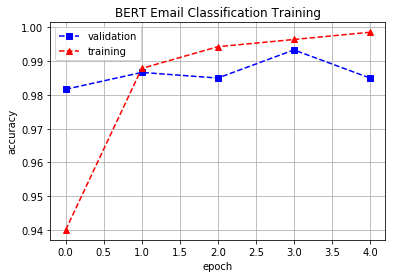

In [23]:
import matplotlib.pyplot as plt

df_history = pd.DataFrame(history.history)
fig,ax = plt.subplots()
plt.plot(range(df_history.shape[0]),df_history['val_acc'],'bs--',label='validation')
plt.plot(range(df_history.shape[0]),df_history['acc'],'r^--',label='training')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('BERT Email Classification Training')
plt.legend(loc='best')
plt.grid()
plt.show()

fig.savefig('BERTConvergence.eps', format='eps')
fig.savefig('BERTConvergence.pdf', format='pdf')
fig.savefig('BERTConvergence.png', format='png')
fig.savefig('BERTConvergence.svg', format='svg')

**Make figures downloadable to local system in interactive mode**

In [24]:
from IPython.display import HTML
def create_download_link(title = "Download file", filename = "data.csv"):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)

create_download_link(filename='BERTConvergence.svg')